# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [ ]:
pip install --upgrade pip

In [ ]:
# Install required packages (once per virtual environment)
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost

In [1]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# ML packages
'''
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
'''
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
'''
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
'''
# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings

C:\Users\ykatsuhara\AppData\Local\Temp\ipykernel_25216\3708599080.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)


def display_metrics_cm(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual int', 'actual letter'], columns=['predicted int', 'predicted letter'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)


In [3]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label

# All symbols classifier

## Data Preparation

In [63]:
#For a preliminary analysis
train_subset = train.sample(n= 5000, replace=False, random_state=42)
valid_subset = valid.sample(n= 2000, replace=False, random_state=42)

In [65]:
# train_subset = train
# valid_subset = valid

In [70]:
# Set the predictors and target
X = train_subset.drop('label',axis=1)
y = train_subset.label

# Stratified sampling divides the data set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Check the size of each dataset
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_test.shape[0])

Training set size: 3500
Validation set size: 1500


## Build XGBoost

In [71]:
# All symbols classifier: XGBoost
task = 'All_symbols'
model_name = 'xgboost'

# Initializa XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate the model
xgb_clf.fit(X_train['image_flat'].tolist(),y_train)
y_pred = xgb_clf.predict(X_test['image_flat'].tolist())



In [72]:
y_train

417545    23
384991     6
623514    53
205057     5
31003     32
          ..
20097     24
292774    53
297110     2
282200     6
28599      7
Name: label, Length: 3500, dtype: uint8

In [73]:
# Calculate performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred,average='weighted',zero_division=0)
rec = recall_score(y_test, y_pred,average='weighted',zero_division=0)
f1 = f1_score(y_test, y_pred,average='weighted',zero_division=0)
cm = confusion_matrix(y_test, y_pred)

In [74]:
metrics_dict = {
    'All_symbols': {
        'xgboost': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [75]:
# Store the results to metrics_dict
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  }

In [76]:
# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.61,0.576889,0.61,0.588394


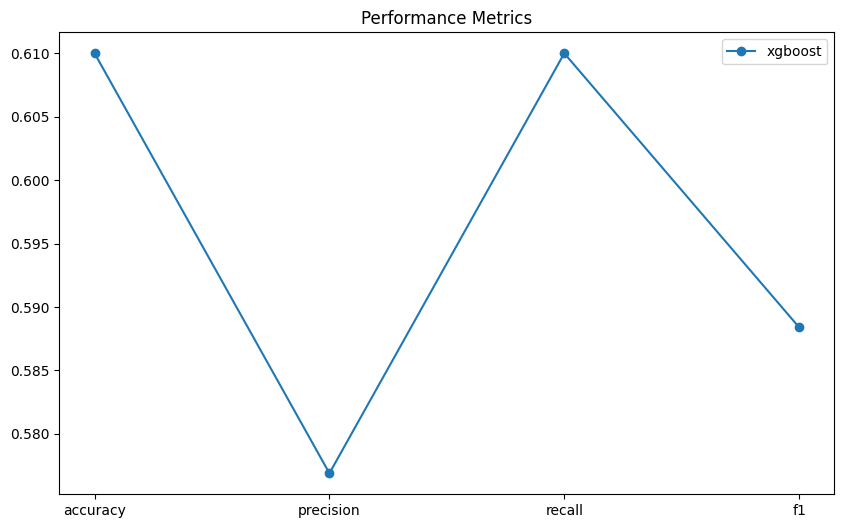

In [77]:
# Visualise the performance
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['All_symbols'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['All_symbols'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics')

# show the plot
plt.show()

## Investigate subsets

In [78]:
# Investigate subsets
# Make subsets
## O and 0
symbols_list = ['O', '0']
mask_valid = X_test['class'].apply(lambda x: x in symbols_list)
valid_01_X = X_test[mask_valid]
valid_01_y = y_test[mask_valid]
valid_01_X.reset_index(drop=True, inplace=True)
valid_01_y.reset_index(drop=True, inplace=True)
## l and 1
symbols_list = ['l', '1']
mask_valid = X_test['class'].apply(lambda x: x in symbols_list)
valid_02_X = X_test[mask_valid]
valid_02_y = y_test[mask_valid]
valid_02_X.reset_index(drop=True, inplace=True)
valid_02_y.reset_index(drop=True, inplace=True)
## Z and 2
symbols_list = ['Z', '2']
mask_valid = X_test['class'].apply(lambda x: x in symbols_list)
valid_03_X = X_test[mask_valid]
valid_03_y = y_test[mask_valid]
valid_03_X.reset_index(drop=True, inplace=True)
valid_03_y.reset_index(drop=True, inplace=True)


In [79]:
metrics_dict_subsets = {
    'Investigate_subsets_using_xgboost' : { # task name (Investigate_subsets_using_xgboost)
        'O vs 0': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'confusion matrix': []
        },
        'l vs 1': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'confusion matrix': []
        },
        'Z vs 2': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'confusion matrix': []
        }
    }
}

In [80]:
metrics_dict_subsets

{'Investigate_subsets_using_xgboost': {'O vs 0': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': [],
   'confusion matrix': []},
  'l vs 1': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': [],
   'confusion matrix': []},
  'Z vs 2': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': [],
   'confusion matrix': []}}}

In [81]:
# All symbols classifier: XGBoost
task = 'Investigate_subsets_using_xgboost'

y_pred_01 = xgb_clf.predict(valid_01_X['image_flat'].tolist())
y_pred_02 = xgb_clf.predict(valid_02_X['image_flat'].tolist())
y_pred_03 = xgb_clf.predict(valid_03_X['image_flat'].tolist())

# O vs 0
## Calculate performance metrics
model_name = 'O vs 0'
acc = accuracy_score(valid_01_y, y_pred_01)
prec = precision_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
rec = recall_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
f1 = f1_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)

unique = valid_01_y.unique()[1]
y_pred_01_replaced = np.where(y_pred_01!=unique,0,y_pred_01)
cm1 = confusion_matrix(valid_01_y, y_pred_01_replaced)

## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 'confusion matrix': cm1
                                 }
# Display performance metrics
display_metrics_cm(task, model_name, metrics_dict_subsets)

# l vs 1
## Calculate performance metrics
model_name = 'l vs 1'
acc = accuracy_score(valid_02_y, y_pred_02)
prec = precision_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)
rec = recall_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)
f1 = f1_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)

unique = valid_02_y.unique()[1]
y_pred_02_replaced = np.where(y_pred_02!=unique,1,y_pred_02)
cm2 = confusion_matrix(valid_02_y, y_pred_02_replaced)

## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 'confusion matrix': cm2
                                 }
# Display performance metrics
display_metrics_cm(task, model_name, metrics_dict_subsets)

# Z vs 2
## Calculate performance metrics
model_name = 'Z vs 2'
acc = accuracy_score(valid_03_y, y_pred_03)
prec = precision_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)
rec = recall_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)
f1 = f1_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)

unique = valid_03_y.unique()[1]
y_pred_03_replaced = np.where(y_pred_03!=unique,2,y_pred_03)
cm3 = confusion_matrix(valid_03_y, y_pred_03_replaced)


## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 'confusion matrix': cm3
                                 }

# Display performance metrics
display_metrics_cm(task, model_name, metrics_dict_subsets)


# Performance Metrics: O vs 0

,accuracy,precision,recall,f1
0,0.51145,0.552305,0.51145,0.530417


# Confusion Matrix: O vs 0

,predicted int,predicted letter
actual int,76,0
actual letter,55,0


# Performance Metrics: l vs 1

,accuracy,precision,recall,f1
0,0.534483,0.602126,0.534483,0.555457


# Confusion Matrix: l vs 1

,predicted int,predicted letter
actual int,73,9
actual letter,29,5


# Performance Metrics: Z vs 2

,accuracy,precision,recall,f1
0,0.759494,0.921353,0.759494,0.83263


# Confusion Matrix: Z vs 2

,predicted int,predicted letter
actual int,74,0
actual letter,5,0


## Improve performance

In [82]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}


In [83]:
 X_test_para = X_test['image_flat'].tolist()

In [84]:
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

In [85]:
grid_search.fit(X_test['image_flat'].tolist(), y_test)

c:\Users\ykatsuhara\Desktop\datasci_223\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")


In [ ]:
winning_mdl = XGBClassifier(**grid_search.best_params_)


In [ ]:
y_pred = winning_mdl.predict(valid_subset['image_flat'].tolist())

In [ ]:
acc = accuracy_score(valid_subset.label, y_pred)
prec = precision_score(valid_subset.label, y_pred,average='weighted',zero_division=0)
rec = recall_score(valid_subset.label, y_pred,average='weighted',zero_division=0)
f1 = f1_score(valid_subset.label, y_pred,average='weighted',zero_division=0)

In [ ]:
metrics_dict_subsets = {
    'All symbols': {
        'xgboost_winning': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [ ]:
## Store performance metrics in dictionary
task = 'All symbols'
model_name = 'xgboost_winning'
metrics_dict_subsets['digit or letters']['xgboost_winning'] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [ ]:
# 1. Create a column for whether each row is a digit(=0) or a letter(=1)
def recategorize(label):
    if str(label).isdigit() and 0 <= int(label) <= 9:
        return 0
    else:
        return 1

train['recategory'] = train['label'].apply(recategorize)
valid['recategory'] = valid['label'].apply(recategorize)
train_subset['recategory'] = train_subset['label'].apply(recategorize)
valid_subset['recategory'] = valid_subset['label'].apply(recategorize)

In [ ]:
# 2. Choose an evaluation metric 
## F1

In [ ]:
# 3. Choose several candidate models to train
## Logistic Regression and XGBoost

In [ ]:
# 4. Divide data to reserve a validation set that will NOT be used in training/testing
## 'valid' is the validation set

In [ ]:
# 5. K-fold train/test
cv = KFold(n_splits=5, shuffle=True, random_state= 42)


scores  = []
test_label = train_subset['recategory']

for train_index, test_index in cv.split(train_subset):
    X_train2, X_test2 = train_subset.iloc[train_index], train_subset.iloc[test_index]
    y_train2, y_test2 = test_label.iloc[train_index],test_label.iloc[test_index]
    X_train2 = X_train2['image_flat'].tolist()
    X_test2 = X_test2['image_flat'].tolist()

 # Initialize XGBoost classifier   
    xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    xgb_clf.fit(X_train2, y_train2)
    
    # Evaluate the model using test data
    y_pred = xgb_clf.predict(X_test2)
    score = f1_score(y_test2, y_pred,average='macro')
    scores.append(score)

# Calculate average scores
average_score = np.mean(scores)
print(f"Average score of XGBoost: {average_score}")

In [ ]:
for train_index, test_index in cv.split(X):
    X_train2, X_test2 = train_subset.iloc[train_index], train_subset.iloc[test_index]
    y_train2, y_test2 = test_label.iloc[train_index],test_label.iloc[test_index]

    scaler = StandardScaler()
    X_train2_scaled = scaler.fit_transform(X_train2['image_flat'].tolist())
    X_test2_scaled = scaler.transform(X_test2['image_flat'].tolist())

# Initialize logistic regression classifier
    lr_clf = LogisticRegression(max_iter=1000, random_state=42)

    # Train the model
    lr_clf.fit(X_train2_scaled, y_train2)
    
    # Evaluate the model using test data
    y_pred = lr_clf.predict(X_test2_scaled)
    score = f1_score(y_test2, y_pred,average='macro')
    scores.append(score)

# Calculate the average score
average_score = np.mean(scores)
print(f"Average score of Logistic: {average_score}")

In [ ]:
##4. (*Optional*) Perform hyper-parametric search
## XGBoost




##5. Record the model evaluation metrics
##6. Repeat with a new train/test split

## Improve the performance

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}

In [ ]:
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

In [ ]:
grid_search.fit(X_test2['image_flat'].tolist(), y_test2)

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Scores of XGBoost: {best_score}")


In [ ]:
# Buil the best model
best_mdl_XGBoost = XGBClassifier(**grid_search.best_params_)

In [ ]:
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(lr_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)


grid_search.fit(X_test2['image_flat'].tolist(), y_test2)

prin("Best parameters:", grid_search.best_params_)
print("Best scores of Logistic:", grid_search.best_score_)

## Performance the winning model in the valid data

In [ ]:
# Build the winning model
best_mdl_Logistic = LogisticRegression(**grid_search.best_params_)

In [ ]:
winning_mdl = best_mdl_XGBoost

In [ ]:
y_pred = winning_mdl.predict(valid_subset['image_flat'].tolist())

In [ ]:
# Calculate the scores of the best model
acc = accuracy_score(valid_subset.label, y_pred)
prec = precision_score(valid_subset.label, y_pred,average='weighted',zero_division=0)
rec = recall_score(valid_subset.label, y_pred,average='weighted',zero_division=0)
f1 = f1_score(valid_subset.label, y_pred,average='weighted',zero_division=0)

In [ ]:
metrics_dict_subsets = {
    'digit or letters': {
        'xgboost_winning': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [] 
        }
    }
}

In [ ]:
## Store performance metrics in dictionary
task = 'digit or letters'
model_name = 'xgboost_winning'
metrics_dict_subsets['digit or letters']['xgboost_winning'] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

## Improve the pergormance of Logistic Regression model

In [ ]:
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(lr_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)


grid_search.fit(X_test2['image_flat'].tolist(), y_test2)

prin("Best parameters:", grid_search.best_params_)
print("Best scores:", grid_search.best_score_)

In [ ]:
# Build the winning model
winning_mdl = LogisticRegression(**grid_search.best_params_)

In [ ]:
y_pred = winning_mdl.predict(valid_subset['image_flat'].tolist())

In [ ]:
# Calculate the scores
acc = accuracy_score(valid_subset.label, y_pred)
prec = precision_score(valid_subset.label, y_pred,average='weighted',zero_division=0)
rec = recall_score(valid_subset.label, y_pred,average='weighted',zero_division=0)
f1 = f1_score(valid_subset.label, y_pred,average='weighted',zero_division=0)

In [ ]:
metrics_dict_subsets = {
    'digit or letters': {  
        'logistic_winning': { 
            'accuracy': [], 
            'precision': [], 
            'recall': [], 
            'f1': [] 
        }
    }
}

In [ ]:
## Store performance metrics in dictionary
task = 'digit or letters'
model_name = 'logistic_winning'
metrics_dict_subsets['digit or letters']['xgboost_winning'] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

In [ ]:
#6. Promote winner, apply model to validation set

In [ ]:
winning_mdl = XGBClassifier(learning_rate= 0.1, max_depth= 5, min_child_weight= 1, n_estimators= 100, subsample= 0.8)
winning_mdl.fit(X_test2['image_flat'].tolist(), y_test2['recategory'])

In [ ]:
y_pred = winning_mdl.predict(valid['image_flat'].tolist())

In [ ]:
acc = accuracy_score(valid_subset['recategory'], y_pred)
prec = precision_score(valid_subset['recategory'], y_pred,average='weighted',zero_division=0)
rec = recall_score(valid_subset['recategory'], y_pred,average='weighted',zero_division=0)
f1 = f1_score(valid_subset['recategory'], y_pred,average='weighted',zero_division=0)

In [ ]:
metrics_dict_subsets = {
    'digit or letters': {  # タスク名
        'xgboost_winning': {  # モデル名
            'accuracy': [],  # 精度を格納するリスト
            'precision': [],  # 適合率を格納するリスト
            'recall': [],  # 再現率を格納するリスト
            'f1': []  # F1スコアを格納するリスト
        }
    }
}

In [ ]:
## Store performance metrics in dictionary
task = 'digit or letters'
model_name = 'xgboost_winning'
metrics_dict_subsets['digit or letters']['xgboost_winning'] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

In [ ]:
#7. (*Optional*) Perform hyper-parametric search, if applicable


In [ ]:
#8. Report model performance

In [ ]:
# 最適なモデルパラメータでモデルを再初期化
best_model = LogisticRegression(**grid_search.best_params_)

# トレーニングデータ全体でモデルを再トレーニング
best_model.fit(X_train, y_train)

# バリデーションセットを使用してモデルを評価
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"バリデーションセットの精度: {val_accuracy}")
print(f"バリデーションセットのF1スコア: {val_f1}")


In [ ]:
acc = accuracy_score(valid_01_y, y_pred_01)
prec = precision_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
rec = recall_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
f1 = f1_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)